In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
import tfe
from geopy.distance import vincenty

## Funciones Auxiliares

In [33]:
#Función que filtra columnas de acuerdo a una lista de indices
#filter_features: matrix list -> matrix
def filter_features(vector,selected_features):
    selected = []
    for i in range(len(selected_features)):
        selected.append(features_dict[selected_features[i]])
    return vector[:,selected]

In [44]:
#Función que identifica cuantos rois comparten dos grupos de rois y cual es la minima distancia que se descarta como
#rois compartidos
#share_rois: list(dict) list(dict) -> [int,int]
def share_rois(rois_a,rois_b):
    shared = 0
    rois = [rois_a,rois_b]
    index = np.argmin([len(rois_a),len(rois_b)])
    other_index = abs(index-1)
    min_distance = -1
    for i in range(len(rois[index])):
        an_a_roi = rois[index][i]
        lat_a_roi = an_a_roi['lat']
        long_a_roi = an_a_roi['long']
        for j in range(len(rois[other_index])):
            an_b_roi = rois[other_index][j]
            lat_b_roi = an_b_roi['lat']
            long_b_roi = an_b_roi['long']
            a_distance = vincenty((lat_a_roi,long_a_roi),(lat_b_roi,long_b_roi)).meters
            if a_distance < 500:
                shared +=1
            elif min_distance == -1 or min_distance > a_distance:
                min_distance = a_distance
    return [shared,min_distance]

In [61]:
def compare_vectors(vector_a,vector_b,rois_a,rois_b,limit,min_shared):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    shared = []
    for i in range(limit):
        rois_abril = rois_a[i]
        for j in range(limit):
            rois_septiembre = rois_b[j]
            min_shared_x = min(len(rois_abril),len(rois_septiembre),min_shared)
            share_RoIs,min_distance_not_shared = share_rois(rois_abril[0],rois_septiembre[0])
            shared.append(share_RoIs)
            if share_RoIs >= min_shared_x:
                a_sequence = vector_a[i]
                b_sequence = vector_b[j]
                dist = np.linalg.norm(np.asarray(a_sequence)-np.asarray(b_sequence))
                a_matrix[i,j] = -dist
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [ ]:
def get_n_correct(a_matrix,limit):
    identified_indexs = [] #almacena los indices de que secuencia fue seleccionada como match
    wrong_indexs = [] # almacena los indices de los que se clasificaron incorrectamente
    correct_indexs = [] # almacena los indices de los que se clasificaron correctamente
    selected_distance = [] # almacena la distancia de los seleccionados
    n_identified = 0
    for i in range(limit):
        the_index = np.argmax(a_matrix[:,i])
        selected_distance.append(np.max(a_matrix[:,i]))
        identified_indexs.append(the_index)
        if(the_index!=i):
            wrong_indexs.append(the_index)
        else:
            correct_indexs.append(the_index)
            n_identified += 1
    return [n_identified,selected_distance,wrong_indexs]


## Obtener datos

In [7]:
with open('data/datos_abril_sep_sequence.pickle') as f:
    datos_abril = pickle.load(f)
    datos_septiembre = pickle.load(f)

In [16]:
with open('data/feature_data.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [42]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [48]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

## Seleccionar Features para la comparación

In [31]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [32]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

In [52]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy","random_entropy",\
                     "p100_diff_last_origin","p100_diff_first_origin","start_time","end_time",\
                     "traveled_days","frequence_regularity","P100_bus_trips"]

In [53]:
abril_selected_features = filter_features(abril_vectors,selected_features)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features)

## Comparar

In [54]:
a_matrix = compare_vectors(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,limit,1)

5731.19753885


In [55]:
5731.19753885/60


95.51995898083332

In [56]:
n_identified,selected_distance,wrong_indexs = get_n_correct(a_matrix,limit)

In [57]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

20.08%


In [58]:
counter = []
for i in range(limit):
    #contar con cuantos comparte cada secuencia
    count = sum(x != -1 for x in a_matrix[i,:])
    counter.append(count)

Hay rois que son muy compartidos, por tanto quizás convenga ser más exigentes

(array([ 4.,  0.,  4., ...,  0.,  0.,  1.]),
 array([  1.00000000e+00,   2.11037344e+00,   3.22074689e+00, ...,
          1.33677925e+03,   1.33788963e+03,   1.33900000e+03]),
 <a list of 1205 Patch objects>)

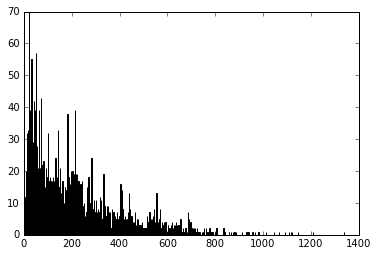

In [60]:
plt.hist(counter,1205)

In [ ]:
a_matrix = compare_vectors(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,limit,2)

In [ ]:
n_identified_2,selected_distance_2,wrong_indexs_2 = get_n_correct(a_matrix,limit)